In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [3]:
base_path = "../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"

In [14]:
batch_size=64
image_gen =  ImageDataGenerator(
        rescale = 1./255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


train_flow= image_gen.flow_from_directory(
    base_path + 'train/',
    target_size = (299, 299),
    batch_size = batch_size,
    #color_mode='grayscale',
    class_mode ='binary'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size = (299, 299),
    batch_size = batch_size,
    #color_mode='grayscale',
    class_mode = 'binary'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size = (299, 299),
    batch_size = 1,
    shuffle = False,
    #color_mode='grayscale',
    class_mode ='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

In [6]:
# def build_model(pretrained):
#     model = Sequential([
#         pretrained,
#         layers.GlobalAveragePooling2D(),
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(
#         loss='binary_crossentropy',
#         optimizer=Adam(),
#         metrics=['accuracy']
#     )
    
#     return mode

In [26]:
Inception = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299,299,3) )
model = Sequential([ 
        Inception,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [28]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, metrics=['accuracy'])

In [29]:
from keras.callbacks import ModelCheckpoint
filepath = "saved-final-model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [30]:
train_steps = 100000//100
valid_steps = 20000//100

history = model.fit_generator(
    train_flow,
    epochs =10,
    callbacks= callbacks_list,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps
)

Epoch 1/10
1000/1000 [==============================] - 1183s 1s/step - loss: 0.1246 - accuracy: 0.9485 - val_loss: 0.0575 - val_accuracy: 0.9778

Epoch 00001: val_accuracy improved from -inf to 0.97781, saving model to saved-final-model.h5
Epoch 2/10
1000/1000 [==============================] - 1134s 1s/step - loss: 0.0421 - accuracy: 0.9841 - val_loss: 0.0919 - val_accuracy: 0.9667

Epoch 00002: val_accuracy did not improve from 0.97781
Epoch 3/10
1000/1000 [==============================] - 1132s 1s/step - loss: 0.0309 - accuracy: 0.9886 - val_loss: 0.1130 - val_accuracy: 0.9627

Epoch 00003: val_accuracy did not improve from 0.97781
Epoch 4/10
1000/1000 [==============================] - 1127s 1s/step - loss: 0.0251 - accuracy: 0.9906 - val_loss: 0.0402 - val_accuracy: 0.9841

Epoch 00004: val_accuracy improved from 0.97781 to 0.98406, saving model to saved-final-model.h5
Epoch 5/10
1000/1000 [==============================] - 1118s 1s/step - loss: 0.0220 - accuracy: 0.9919 - val_l

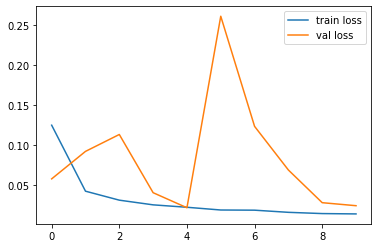

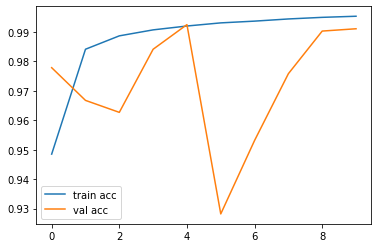

In [31]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [45]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

In [44]:
from sklearn import metrics

In [46]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.99989602
AP Score: 0.9998956293080502

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10000
           1       0.98      1.00      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [47]:
y_test1 = np.array(y_test)
y_test1

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [48]:
y_pred1 = y_pred.copy()
np.where(y_pred1 > 0.5, 1, 0)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [49]:
y_pred2 = y_pred1.flatten()
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
y_pred2

array([0, 0, 0, ..., 1, 1, 1])

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[9817  183]
 [   7 9993]]
acc: 0.9905
sensitivity: 0.9817
specificity: 0.9993


<AxesSubplot:>

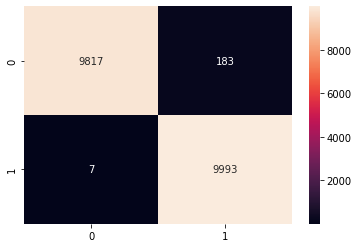

In [51]:
import seaborn as sns
sns.heatmap(cm,annot=True, fmt='g')

In [52]:
train_flow.class_indices

{'fake': 0, 'real': 1}